# Dataset: Kaggle
## https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224

# Load Data

In [9]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import zipfile
import os

# Path ke file zip
zip_file_path = '/content/drive/MyDrive/Dataset/dataset kopi.zip'

# Direktori tujuan untuk menyimpan file yang diekstrak
extract_dir = '/content/drive/MyDrive/Dataset/dataset kopi'

# Buat folder jika belum ada
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Buka file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Loop melalui semua file di dalam zip
    for file_name in zip_ref.namelist():
        # Periksa apakah file tersebut adalah gambar (misal file dengan ekstensi .jpg atau .png)
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            # Ekstrak file gambar ke direktori tujuan
            zip_ref.extract(file_name, extract_dir)

            # Cetak nama file yang diekstrak (opsional)
            print(f"File diekstrak: {file_name}")

# Menampilkan semua file yang ada di dalam folder zip
file_names = zip_ref.namelist()
file_names


File diekstrak: test/Dark/dark (1).png
File diekstrak: test/Dark/dark (10).png
File diekstrak: test/Dark/dark (100).png
File diekstrak: test/Dark/dark (11).png


KeyboardInterrupt: 

# Library

In [11]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pathlib
from sklearn import svm
from PIL import Image, ImageEnhance
from tqdm import tqdm
from collections import Counter
from scipy.stats import skew
from skimage import io, exposure
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, BatchNormalization, RandomBrightness
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import tensorflow as tf
import math

# Path ke folder data test
test_dir = "/content/drive/MyDrive/Dataset/dataset kopi/test"

# Load seluruh data test
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    shuffle=True,  # Pastikan data diacak
    seed=123
)

# Hitung jumlah batch untuk pembagian
test_size = len(test_dataset)
validation_size = math.ceil(test_size / 2)  # Setengah untuk validasi
test_size = test_size - validation_size  # Sisanya untuk testing

# Split dataset
validation_dataset = test_dataset.take(validation_size)
test_dataset = test_dataset.skip(validation_size)

# Print jumlah batch di tiap subset
print(f"Validation batches: {len(validation_dataset)}")
print(f"Test batches: {len(test_dataset)}")


Found 400 files belonging to 4 classes.
Validation batches: 7
Test batches: 6


In [ ]:
import os
from PIL import Image

# Path ke folder di Google Drive
valid_dir = "/content/drive/MyDrive/dataset kopi/valid"
os.makedirs(valid_dir, exist_ok=True)

# Simpan setiap gambar validasi ke folder di Google Drive
for i, (images, labels) in enumerate(validation_dataset):
    for j, (image, label) in enumerate(zip(images, labels)):
        label_dir = os.path.join(valid_dir, str(label.numpy()))  # Subfolder per label
        os.makedirs(label_dir, exist_ok=True)
        img_path = os.path.join(label_dir, f"img_{i}_{j}.jpg")
        img = tf.cast(image, tf.uint8).numpy()
        Image.fromarray(img).save(img_path)

print(f"Data validasi berhasil disimpan di folder Google Drive: {valid_dir}")


Data validasi berhasil disimpan di folder Google Drive: /content/drive/MyDrive/dataset kopi/valid


In [ ]:
import os

# Path direktori
train_dir = "/content/drive/MyDrive/Dataset/dataset kopi/train"
test_dir = "/content/drive/MyDrive/Dataset/dataset kopi/test"
valid_dir = "/content/drive/MyDrive/Dataset/dataset kopi/valid"

# Fungsi untuk menghitung jumlah file dalam direktori
def count_files_in_directory(directory):
    total_files = 0
    for root, _, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Hitung jumlah data
num_train = count_files_in_directory(train_dir)
num_test = count_files_in_directory(test_dir)
num_valid = count_files_in_directory(valid_dir)

print(f"Jumlah data:")
print(f"Train: {num_train}")
print(f"Valid: {num_valid}")
print(f"Test: {num_test}")


Jumlah data:
Train: 1200
Valid: 224
Test: 400


# Pre-Processing

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

h, w = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4
CLASSES = ['Dark', 'Green', 'Light', 'Medium']
DATASET_PATH = "/content/drive/MyDrive/Dataset/dataset kopi"
train_dir = f'{DATASET_PATH}/train'
val_dir = f'{DATASET_PATH}/valid'
test_dir = f'{DATASET_PATH}/test'
features = []
labels = []

In [ ]:
import os

def count_images_per_class(dataset_path, classes, subsets=['train', 'test', 'valid']):
    result = {}

    for subset in subsets:
        subset_path = os.path.join(dataset_path, subset)
        if not os.path.isdir(subset_path):
            result[subset] = {class_name: 0 for class_name in classes}
            continue

        subset_counts = {}
        for class_name in classes:
            class_path = os.path.join(subset_path, class_name)
            if os.path.isdir(class_path):
                subset_counts[class_name] = len(os.listdir(class_path))
            else:
                subset_counts[class_name] = 0

        result[subset] = subset_counts

    return result

class_counts = count_images_per_class(DATASET_PATH, CLASSES)
print(class_counts)


{'train': {'Dark': 300, 'Green': 300, 'Light': 300, 'Medium': 300}, 'test': {'Dark': 100, 'Green': 100, 'Light': 100, 'Medium': 100}, 'valid': {'Dark': 57, 'Green': 57, 'Light': 57, 'Medium': 53}}


# EDA

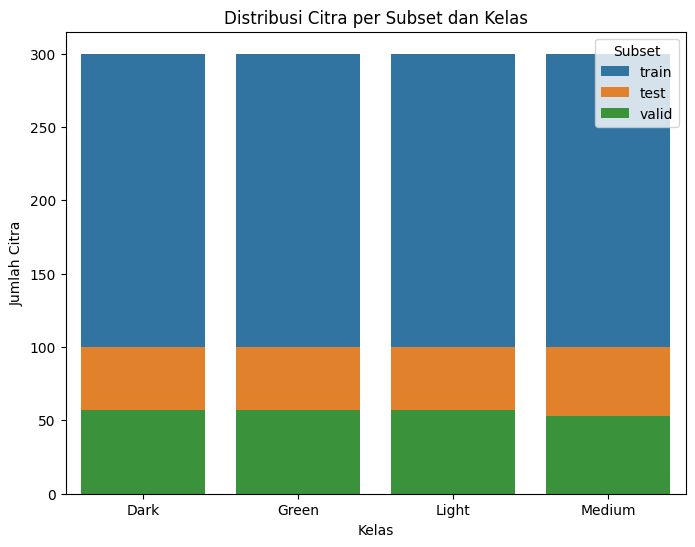

In [ ]:
# Visualisasi distribusi gambar per kelas
subset_totals = {subset: sum(counts.values()) for subset, counts in class_counts.items()}
plt.figure(figsize=(8, 6))

for subset, counts in class_counts.items():
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), label=subset)

plt.title('Distribusi Citra per Subset dan Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Citra')
plt.legend(title="Subset", loc="upper right")
plt.show()

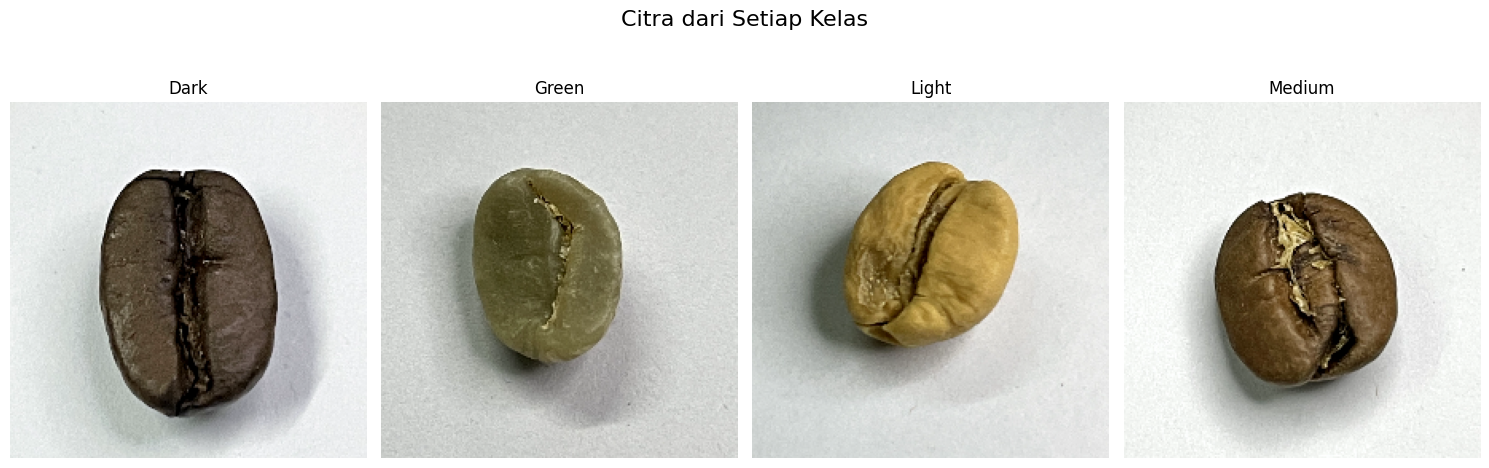

In [ ]:
NUM_CLASSES = len(CLASSES)
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(15, 5))
fig.suptitle('Citra dari Setiap Kelas', fontsize=16)

for i, class_name in enumerate(CLASSES):
    train_class_path = os.path.join(DATASET_PATH, 'train', class_name)
    if os.path.isdir(train_class_path) and len(os.listdir(train_class_path)) > 0:
        img_path = os.path.join(train_class_path, os.listdir(train_class_path)[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(class_name)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{class_name}\n(Tidak Ada Gambar)")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [13]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(h, w),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(h, w),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(h, w),
    batch_size=BATCH_SIZE
)

Found 1200 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


# Augmented

In [14]:
# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),  # Flip secara horizontal dan vertikal
    RandomRotation(0.2),  # Rotasi hingga 20%
    RandomZoom(0.2),      # Zoom hingga 20%
    RandomBrightness(0.2) # Perubahan kecerahan hingga 20%
])

# Model

In [15]:
model = Sequential([
    Rescaling(1./255, input_shape=(h, w, 3)),  # Input layer with defined input shape
    data_augmentation,  # Data augmentation after input layer
    Conv2D(32, (3, 3), activation='relu'),  # Convolutional layer
    MaxPooling2D(2, 2),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer
    MaxPooling2D(2, 2),  # Max pooling layer
    Conv2D(128, (3, 3), activation='relu'),  # Convolutional layer
    MaxPooling2D(2, 2),  # Max pooling layer
    Flatten(),  # Flatten layer
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Mengatasi overfitting
    Dense(NUM_CLASSES, activation='softmax')  # Output layer
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#Training
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.2483 - loss: 6.4295 - val_accuracy: 0.1116 - val_loss: 1.3872
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 178s 5s/step - accuracy: 0.2483 - loss: 1.3865 - val_accuracy: 0.2634 - val_loss: 1.3863
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.2527 - loss: 1.3990 - val_accuracy: 0.2545 - val_loss: 1.3864
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.2355 - loss: 1.3864 - val_accuracy: 0.2545 - val_loss: 1.3865
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.2315 - loss: 1.3864 - val_accuracy: 0.2545 - val_loss: 1.3863
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.2173 - loss: 1.3864 - val_accuracy: 0.2545 - val_loss: 1.3863
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.2230 - loss: 1.3864 - val_accuracy: 0.2545 - val_loss: 1.3863
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.2305 - loss: 1.3864 - val_accuracy: 0.2545 - v

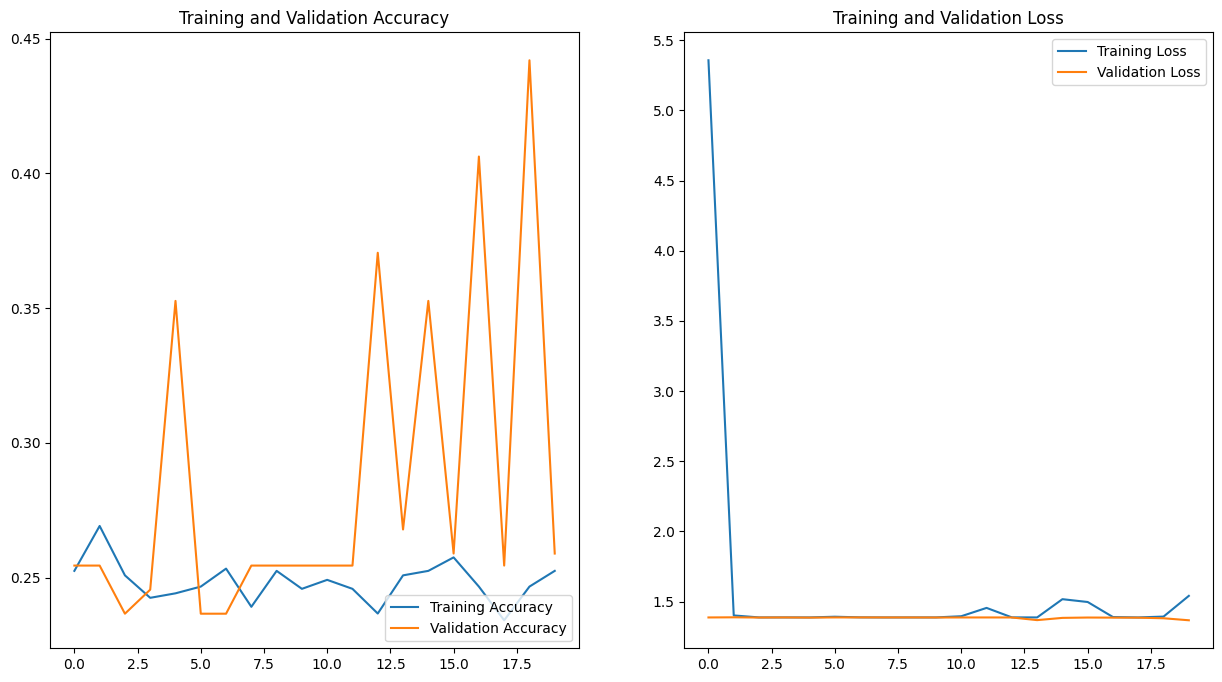

In [ ]:
#Evaluasi
#Menampilkan Learning Curve

# Akurasi
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2664 - loss: 1.3807
Test accuracy : 0.2544642984867096
Test loss : 1.3823808431625366


In [18]:
y_true = []
y_pred = []
for images, labels in val_ds:
    batch_predictions = model.predict(images)
    batch_pred_labels = np.argmax(batch_predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(batch_pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [19]:
# Get unique labels from y_true (assuming they represent actual class indices)
unique_labels = np.unique(y_true)

# Update CLASSES to match the actual class labels
CLASSES = [str(label) for label in unique_labels]

print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

           0       0.25      1.00      0.41        57
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00        53

    accuracy                           0.25       224
   macro avg       0.06      0.25      0.10       224
weighted avg       0.06      0.25      0.10       224



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Pre-trained


In [20]:
# Load VGG16 Pretrained Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create the Model
model = Sequential([
    base_model,  # VGG16 pretrained base
    Flatten(),  # Flatten the output
    Dense(256, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(6, activation='softmax')  # Output layer (6 classes: adjust to your dataset)
])

# Kompilasi model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,  # Changed EPOCHS to epochs
    validation_data=val_ds
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 837s 22s/step - accuracy: 0.5184 - loss: 25.7672 - val_accuracy: 0.9375 - val_loss: 0.8624
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 836s 21s/step - accuracy: 0.8836 - loss: 1.0161 - val_accuracy: 0.9777 - val_loss: 0.0941
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 864s 21s/step - accuracy: 0.9216 - loss: 0.3155 - val_accuracy: 0.9643 - val_loss: 0.0791
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 802s 21s/step - accuracy: 0.9335 - loss: 0.2355 - val_accuracy: 0.9777 - val_loss: 0.0468
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 807s 21s/step - accuracy: 0.9340 - loss: 0.2327 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 818s 22s/step - accuracy: 0.9717 - loss: 0.0919 - val_accuracy: 0.9911 - val_loss: 0.0214
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 844s 21s/step - accuracy: 0.9650 - loss: 0.1325 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 819s 22s/step - accuracy: 0.9677 - loss: 0.1238 - val_accuracy: 0

In [ ]:
# Simpan model
model.save("final_model.h5")  # Simpan model ke file .h5
print("Model telah disimpan.")

Model telah disimpan.


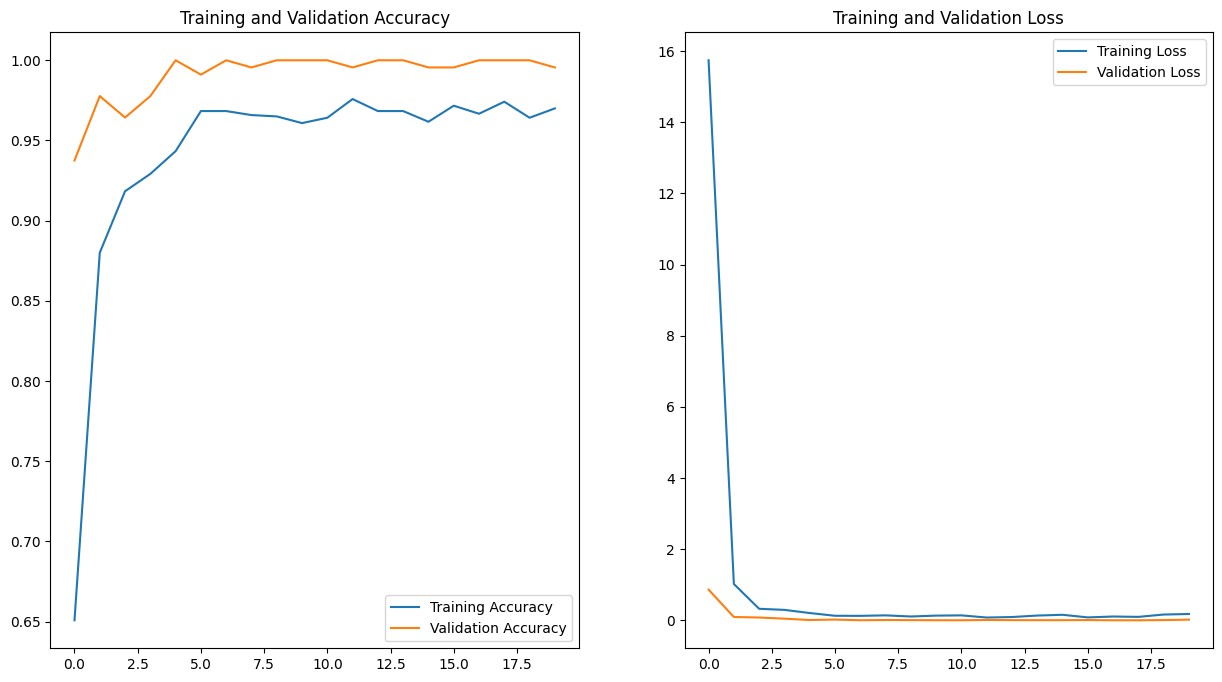

In [ ]:
#Evaluasi
#Menampilkan Learning Curve

# Akurasi
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 131s 18s/step - accuracy: 0.9893 - loss: 0.0420
Test accuracy : 0.9955357313156128
Test loss : 0.01971740834414959


In [ ]:
y_true = []
y_pred = []
for images, labels in val_ds:
    batch_predictions = model.predict(images)
    batch_pred_labels = np.argmax(batch_predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(batch_pred_labels)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


In [ ]:
# Get unique labels from y_true (assuming they represent actual class indices)
unique_labels = np.unique(y_true)

# Update CLASSES to match the actual class labels
CLASSES = [str(label) for label in unique_labels]

print(classification_report(y_true, y_pred, target_names=CLASSES))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        57
           2       0.98      1.00      0.99        57
           3       1.00      0.98      0.99        53

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



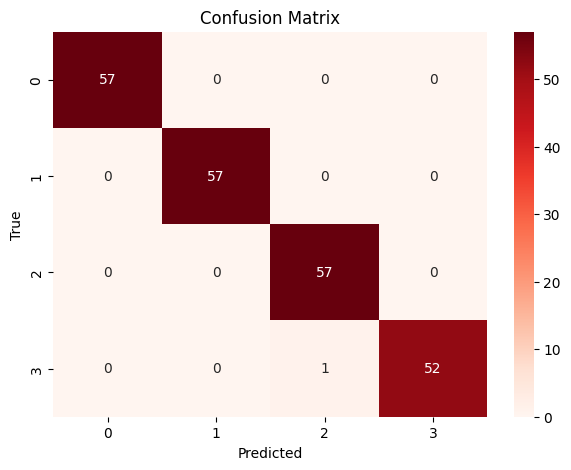

In [ ]:
vscconf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=CLASSES, yticklabels=CLASSES) # Changed classes to CLASSES
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()